In [36]:
import os
import torch
from torch.utils.data import DataLoader
import fcnn, unet
import metrics
from data.loaders import SteelLoader, AitexDataset, SegmentationMnistDataset
from tqdm.auto import tqdm
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import seaborn_image as isns

Specify model and epoch to test

In [37]:
device = torch.device("cuda:1")
res_dir = "training_results/mnist-simplefcn-lr-0.001"
load_epoch = 50

# aitex, mnist, steel   
data = "mnist"

# simplefcn, unet_v2, unet_paper
model_type = "simplefcn"

Load data and model:

In [38]:
if data == "aitex":
        # increasing batch size risks running out of memory for unets
        loader = DataLoader(AitexDataset(train=False), batch_size= 3)
        dim_in = 1
        dim_out = 2
elif data == "steel":
        # increasing batch size risks running out of memory for unets
        loader = SteelLoader(train = False, batch_size=10) 
        dim_in = 3
        dim_out = 5
elif data == "mnist":
        loader = DataLoader(SegmentationMnistDataset(train = False), batch_size= 10)
        dim_in = 1
        dim_out = 11
else:
        raise ValueError("Unkown Dataset: " + data)

In [39]:
# Select the model type to use
if model_type == "simplefcn":
    network = fcnn.SimpleFCN(dim_in = dim_in, dim_out = dim_out)
elif model_type == "unet_v2":
        network = unet.simple_unet_v2(dim_in, dim_out)
elif model_type == "unet_paper":
        network = unet.simple_unet_paper_version(dim_in, dim_out)
else:
        raise ValueError("Unknown model type: " + model_type)

# use selected device
network.to(device)

# load state
network.load_state_dict(
        torch.load(os.path.join(res_dir, f"epoch{load_epoch}state.torch"),
                map_location=device))
  
network.eval()

SimpleFCN(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (prediction_layer): Sequential(
    (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
  )
  (upsample_layers): ModuleList(
    (0): Sequential(
      (0): Upsample(scale_factor=2.0, mode=nearest)
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Sequential(
      (0): Ups

Calculate the confusion matrix of predictions:

In [40]:
confusion_matrix = metrics.confusion_matrix([], [], n_classes= dim_out)

# confusion matrix if we agglomerate all detection classes in to one:
# confusion on whether there is a detection or not
null_confusion_matrix = metrics.confusion_matrix([], [], n_classes = 2)

In [41]:
for x, y in tqdm(loader):
    
    pred_probs = network(x.to(device)).to("cpu").detach()

    # update the confusion matrix
    null_class = y.shape[1] - 1 # channel for no detection is last

    pred_labels = np.array(pred_probs.argmax(dim = 1)).flatten()
    true_labels = np.array(y.argmax(dim = 1)).flatten()
    pred_null = (np.array(pred_probs)[:,-1] > 0.5).flatten()

    confusion_matrix += metrics.confusion_matrix(true_labels, pred_labels, y.shape[1])
    null_confusion_matrix += metrics.confusion_matrix(true_labels == null_class, pred_null, 2)

  0%|          | 0/50 [00:00<?, ?it/s]

# Plots

In [42]:
detection_colors = matplotlib.cm.get_cmap("rainbow", dim_out - 1)
c_list = [detection_colors(i / (dim_out - 1)) for i in range(dim_out - 1)] + [(0,0,0)] 
class_colors = matplotlib.colors.LinearSegmentedColormap.from_list("class_colors", c_list)

In [43]:
def plot_confusion_matrix(conf_mat):
    conf_mat = metrics.normalize_confusion(conf_mat)
    metrics.apply_names(conf_mat, mnist = (data == "mnist"))
    plt.figure()
    sns.heatmap(conf_mat, vmin = 0, vmax = 1, annot = True, fmt = ".2f", cmap = "OrRd")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()
    plt.close()

In [44]:
def plot_channels(img: np.ndarray, ground_truth: np.ndarray, pred: np.ndarray, show_channels = None):
    img_sequence = [img]
    nc = ground_truth.shape[0]
    if show_channels is None:
        show_channels = [i for i in range(nc)]
    for c in show_channels:
        img_sequence.append(ground_truth[c])
        img_sequence.append(pred[c])
    
    for i in range(len(img_sequence)):
        if len(img_sequence[i].shape) == 3:
            img_sequence[i] = np.array(img_sequence[i]).transpose(1,2,0)

    plt.figure()
    aspect = img.shape[2] / img.shape[1]
    isns.ImageGrid(img_sequence, col_wrap=1, aspect=aspect, vmin = 0, vmax = 1)

    plt.show()
    plt.close()

In [45]:
def plot_predictions(probs: np.ndarray):
    nc = probs.shape[0]
    normed_lab = (np.argmax(probs, axis = 0)) / (nc - 1)
    
    isns.imgplot(normed_lab, cmap = class_colors, vmin = 0, vmax = 1, cbar = False)

# Metrics

In [46]:
ious = metrics.metric_iou(confusion_matrix)
print(" & ".join([f"{iou:0.2f}" for iou in ious]))

0.62 & 0.78 & 0.32 & 0.54 & 0.57 & 0.58 & 0.62 & 0.70 & 0.58 & 0.55 & 0.99


# Plots For Real This Time

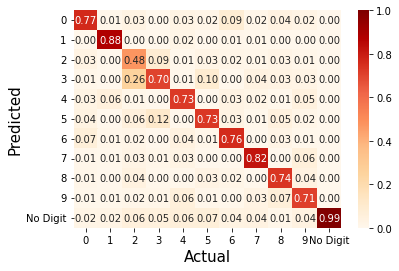

In [47]:
plot_confusion_matrix(confusion_matrix)

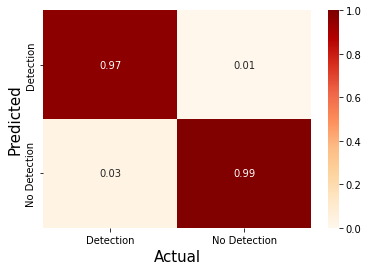

In [48]:
plot_confusion_matrix(null_confusion_matrix)

# Get Example Output

In [49]:
data_member_ind = 1

x, y = loader.dataset[data_member_ind]

x = torch.unsqueeze(x, 0).to(device)

member_pred = np.array(network(x)[0].detach().to("cpu"))

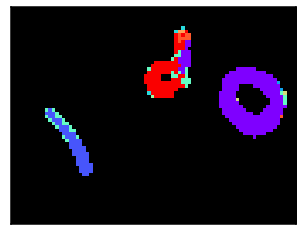

In [50]:
plot_predictions(member_pred)

In [51]:
plot_channels(x[i], np.array(pred_probs[i]), np.array(y[i]))

NameError: name 'i' is not defined